In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
def generate_multivariate_gaussian(n_sample, n_dim, Lambda, U, mu, device='cpu'):
    """
    Generate multivariate Gaussian data using PyTorch.

    Parameters:
    n_sample: int
        Number of samples to generate.
    n_dim: int
        Dimension of the data.
    Lambda: torch.Tensor
        Eigenvalues of the covariance matrix, shape (n_dim,).
    U: torch.Tensor
        Eigenvectors of the covariance matrix, shape (n_dim, n_dim).
    mu: torch.Tensor
        Mean of the data, shape (n_dim,).

    Returns:
    torch.Tensor
        Generated multivariate Gaussian data, shape (n_sample, n_dim).
    """
    # Generate standard normal samples
    Z = th.randn(n_sample, n_dim, device=device)
    # Compute the covariance matrix from eigenvalues and eigenvectors
    # L = th.diag(th.sqrt(Lambda))
    # A = U @ L
    # Generate samples with the specified mean and covariance
    # samples = Z @ A.t() + mu
    # More efficient way to generate samples
    samples = (Z * th.sqrt(Lambda)) @ U.t() + mu
    return samples

# make random orthogonal matrix 
def random_orthogonal(n):
    q, r = th.linalg.qr(th.randn(n, n))
    return q, r


In [9]:

ndim = 512
q, r = th.linalg.qr(th.randn(ndim, ndim))
print(q.shape)
th.allclose(q @ q.T, th.eye(ndim), atol=1e-6)


torch.Size([512, 512])


True

In [4]:
# Example usage
n_sample = 10000
n_dim = 3
Lambda = th.tensor([1.0, 2.0, 3.0])
# U = th.eye(n_dim)
U, r = th.linalg.qr(th.randn(n_dim, n_dim))
mu = th.tensor([1.0, 0.0, -0.5])
samples = generate_multivariate_gaussian(n_sample, n_dim, Lambda, U, mu)
print(samples)

tensor([[ 4.0561, -0.8103,  1.8003],
        [-0.1602,  1.0445,  0.8490],
        [-0.3864, -1.6775, -0.0772],
        ...,
        [-0.3037,  2.4146,  0.3116],
        [ 0.7665, -2.4641,  0.0303],
        [ 1.6013, -0.7196, -0.1399]])


In [5]:
print(samples.mean(dim=0))
print(U.T @ th.cov(samples.T, ) @ U)

tensor([ 0.9895,  0.0162, -0.4950])
tensor([[ 0.9968, -0.0237,  0.0103],
        [-0.0237,  2.0232,  0.0142],
        [ 0.0103,  0.0142,  2.8955]])


In [6]:
eigv_exp = np.random.exponential(scale=1.0, size=(xdim, ))
eigv_exp = sorted(eigv_exp, reverse=True)

NameError: name 'xdim' is not defined

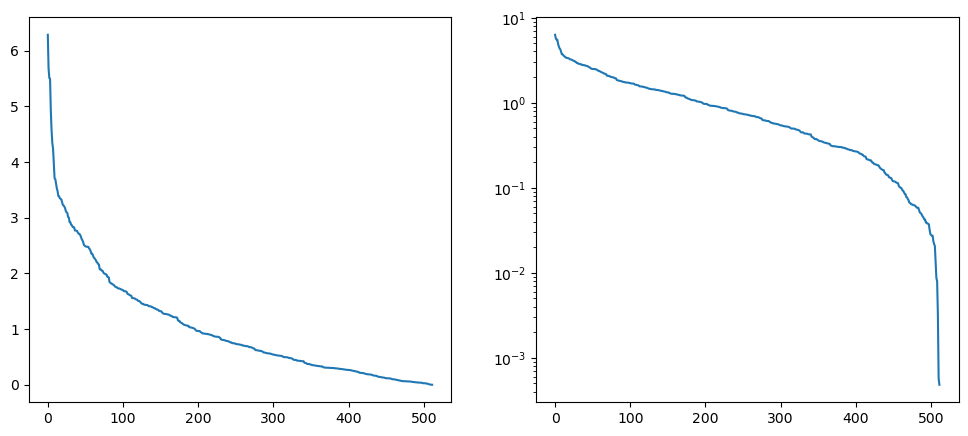

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(eigv_exp)
plt.subplot(1, 2, 2)
plt.semilogy(eigv_exp)

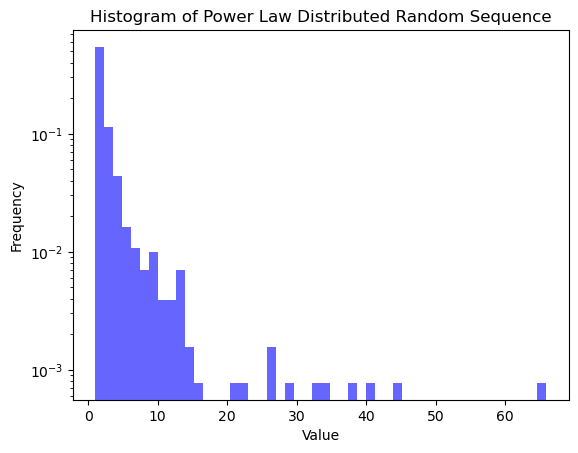

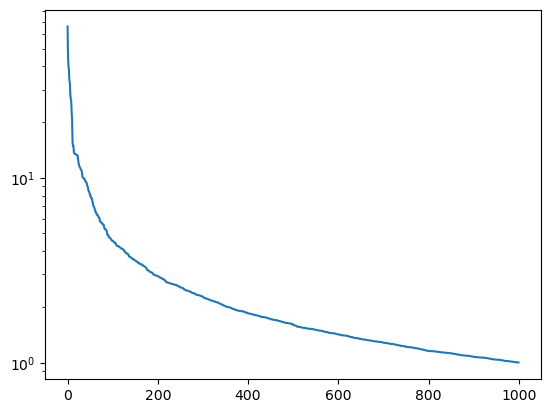

In [ ]:
def generate_power_law_sequence(size, alpha, x_min):
    """
    Generate a random sequence following a power law distribution.
    
    Parameters:
        size (int): Number of random numbers to generate.
        alpha (float): The exponent of the power law distribution.
        x_min (float): The minimum value of x.
        
    Returns:
        numpy.ndarray: A sequence of random numbers following a power law distribution.
    """
    # Generate uniform random numbers between 0 and 1
    r = np.random.rand(size)
    # Transform the uniform random numbers to follow a power law distribution
    x = x_min * (1 - r) ** (-1 / (alpha - 1))
    return x

# Parameters
size = 1000  # Number of random numbers
alpha = 2.5   # Power law exponent
x_min = 1.0   # Minimum value of x

# Generate the power law sequence
power_law_sequence = generate_power_law_sequence(size, alpha, x_min)

# Plot the histogram of the generated sequence
plt.hist(power_law_sequence, bins=50, density=True, alpha=0.6, color='b', log=True)
plt.title('Histogram of Power Law Distributed Random Sequence')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
plt.semilogy(sorted(power_law_sequence, reverse=True))
plt.show()

## Experimental Learning curve (single noise scale $\sigma$)

In [59]:
import math
from tqdm import tqdm, trange
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### One layer Linear regression training case

In [25]:
# Parameters
n_dim = 784
batch_size = 2048
sigma = 0.5
total_steps = 10000
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
# lr = 0.001
# optim_fun = optim.Adam
lr = 1.0 #0.5
optim_fun = optim.SGD
# Create Gaussian Model parameters
# sample eigenvectors
U, _ = random_orthogonal(n_dim)
U = U.to(device)
# sample eigenvalues
Lambda = np.random.exponential(scale=1.0, size=(n_dim, ))
Lambda = sorted(Lambda, reverse=True)
Lambda = th.tensor(Lambda).float().to(device)
mu = th.zeros(n_dim).to(device)
Cov = U @ th.diag(Lambda) @ U.T

# optimal solution W_star
W_star_solu = Cov @ th.inverse(Cov + sigma ** 2 * th.eye(n_dim).to(device))
b_star_solu = mu - mu @ W_star_solu 

# Linear Model parameters
W = th.randn(n_dim, n_dim).to(device) / math.sqrt(n_dim) * 0.0001
# b = th.randn(n_dim).to(device) / math.sqrt(n_dim)
b = th.zeros(n_dim).to(device)
W.requires_grad = True
b.requires_grad = True

# Optimizer
optimizer = optim_fun([W, b], lr=lr)
# Training loop 
stats_traj = []
W_dev_per_mode_col = []
for step in trange(total_steps):
    # Generate samples
    samples = generate_multivariate_gaussian(batch_size, n_dim, Lambda, U, mu, device=device)
    noised_samples = samples + sigma * th.randn_like(samples)
    # Forward pass
    Dx = th.mm(noised_samples, W) + b
    # loss = nn.MSELoss()(Dx, samples)
    loss = th.mean((Dx - samples) ** 2, dim=(0,1))
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Evaluate W, b to optimal solution
    with th.no_grad():
        W_deviation = (W_star_solu - W).pow(2).mean().sqrt()
        b_deviation = (b_star_solu - b).pow(2).mean().sqrt()
        W_deviation_per_mode = ((W_star_solu - W) @ U).pow(2).sum(dim=0).sqrt()
        denoiser_ideal = noised_samples @ W_star_solu + b_star_solu
        D_deviation = (denoiser_ideal - Dx).pow(2).mean().sqrt()
    # Printing and logging
    if (step + 1) % 1000 == 0 or step==0:
        print(f'Step {step + 1}, Loss {loss.item():.4f} W dev {W_deviation.item():.4f} b dev {b_deviation.item():.4f} D dev {D_deviation.item():.4f}')
    stats_traj.append({"step": step + 1, 
                       "loss": loss.item(), 
                       "W_dev": W_deviation.item(), 
                       "b_dev": b_deviation.item(), 
                       "D_dev": D_deviation.item(),})
    W_dev_per_mode_col.append(W_deviation_per_mode.cpu().numpy()) 

stats_df = pd.DataFrame(stats_traj)
W_dev_per_mode_col = np.array(W_dev_per_mode_col)

  1%|▏         | 138/10000 [00:00<00:14, 687.25it/s]

Step 1, Loss 1.0684 W dev 0.0254 b dev 0.0001 D dev 0.9485


 12%|█▏        | 1163/10000 [00:01<00:10, 854.05it/s]

Step 1000, Loss 0.1728 W dev 0.0028 b dev 0.0003 D dev 0.0607


 21%|██        | 2109/10000 [00:02<00:09, 856.41it/s]

Step 2000, Loss 0.1694 W dev 0.0009 b dev 0.0003 D dev 0.0182


 31%|███▏      | 3141/10000 [00:03<00:08, 855.61it/s]

Step 3000, Loss 0.1689 W dev 0.0004 b dev 0.0003 D dev 0.0115


 41%|████      | 4087/10000 [00:04<00:06, 855.21it/s]

Step 4000, Loss 0.1687 W dev 0.0003 b dev 0.0003 D dev 0.0106


 51%|█████     | 5119/10000 [00:06<00:05, 853.54it/s]

Step 5000, Loss 0.1689 W dev 0.0003 b dev 0.0003 D dev 0.0105


 62%|██████▏   | 6151/10000 [00:07<00:04, 852.15it/s]

Step 6000, Loss 0.1690 W dev 0.0003 b dev 0.0003 D dev 0.0105


 71%|███████   | 7096/10000 [00:08<00:03, 849.28it/s]

Step 7000, Loss 0.1692 W dev 0.0003 b dev 0.0003 D dev 0.0105


 81%|████████  | 8118/10000 [00:09<00:02, 848.92it/s]

Step 8000, Loss 0.1692 W dev 0.0003 b dev 0.0003 D dev 0.0104


 91%|█████████▏| 9141/10000 [00:10<00:01, 845.68it/s]

Step 9000, Loss 0.1693 W dev 0.0003 b dev 0.0003 D dev 0.0105


100%|██████████| 10000/10000 [00:11<00:00, 849.32it/s]

Step 10000, Loss 0.1690 W dev 0.0003 b dev 0.0003 D dev 0.0105


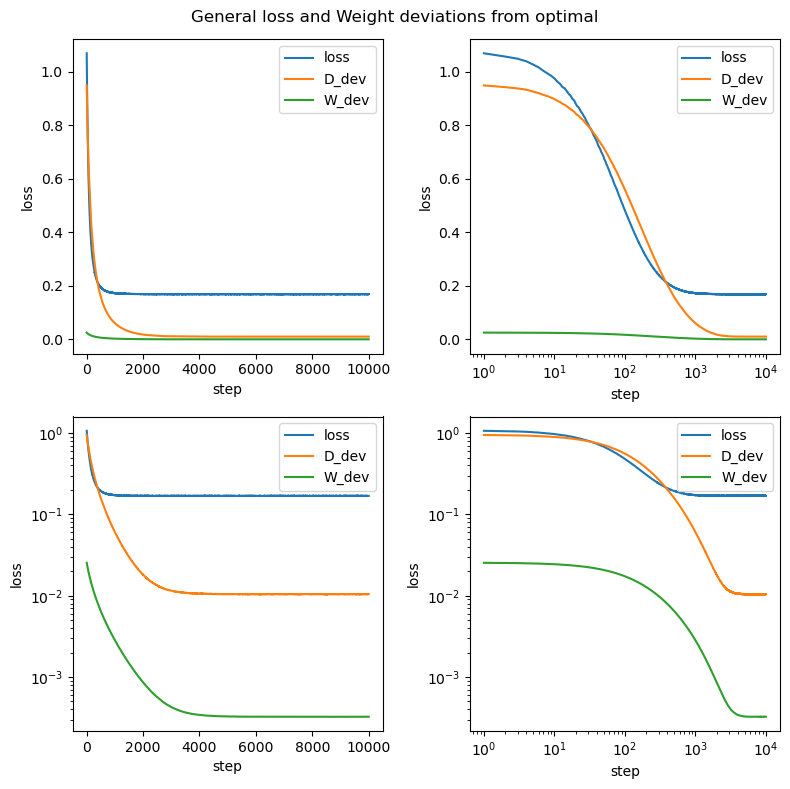

In [41]:
figh, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()
for i in range(4):
    plt.sca(axs[i])
    sns.lineplot(stats_df, x='step', y='loss', ax=axs[i], label='loss')
    sns.lineplot(stats_df, x='step', y='D_dev', ax=axs[i], label='D_dev')
    sns.lineplot(stats_df, x='step', y='W_dev', ax=axs[i], label='W_dev')
    if i % 2 == 1:
        axs[i].set_xscale('log')
    if i >= 2:
        axs[i].set_yscale('log')
    plt.legend()
plt.suptitle(f'General loss and Weight deviations from optimal')
plt.tight_layout()

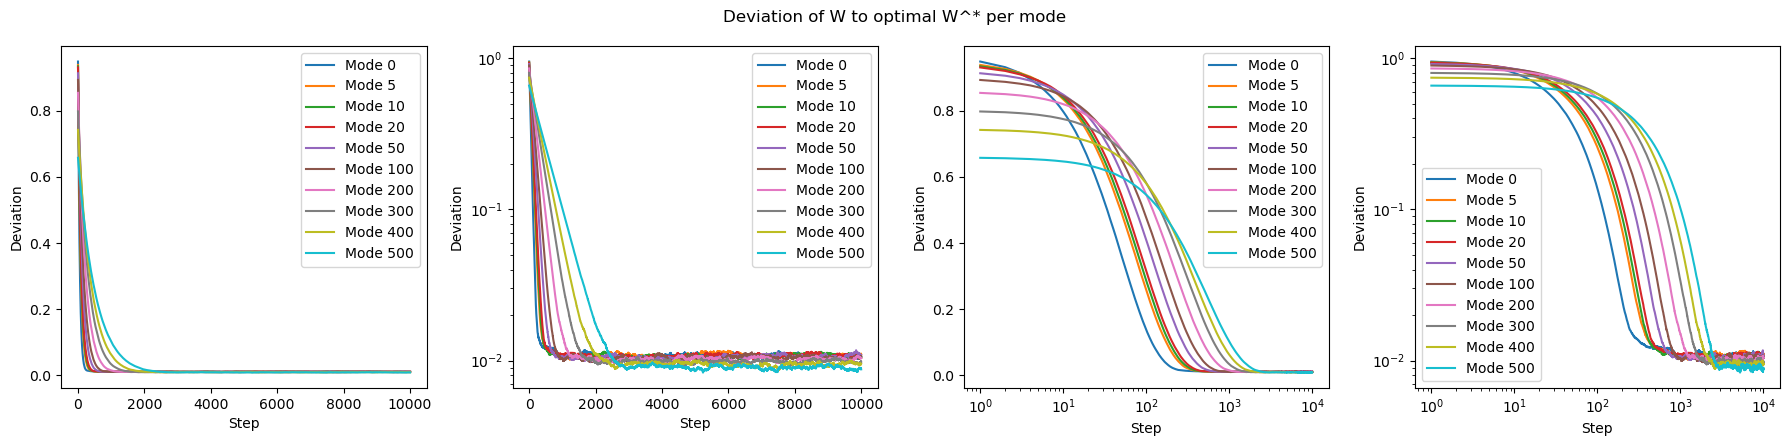

In [43]:
figh, axs = plt.subplots(1, 4, figsize=(18, 4.5))
axs = axs.flatten()
for i, plot_func in enumerate([plt.plot, plt.semilogy, plt.semilogx, plt.loglog]):
    plt.sca(axs[i])
    for eigenN in [0, 5, 10, 20, 50, 100, 200, 300, 400, 500]:
        plot_func(stats_df['step'], W_dev_per_mode_col[:, eigenN], label=f'Mode {eigenN}')
    plt.xlabel('Step')
    plt.ylabel('Deviation')
    plt.legend()
plt.suptitle('Deviation of W to optimal W^* per mode')
plt.tight_layout()
plt.show()

In [ ]:
# Parameters
n_dim = 3072
batch_size = 2048
sigma = 0.5
total_steps = 10000
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
# lr = 0.001
# optim_fun = optim.Adam
lr = 1.0 #0.5
optim_fun = optim.SGD
# Create Gaussian Model parameters
# sample eigenvectors
U, _ = random_orthogonal(n_dim)
U = U.to(device)
# sample eigenvalues
Lambda = np.random.exponential(scale=1.0, size=(n_dim, ))
Lambda = sorted(Lambda, reverse=True)
Lambda = th.tensor(Lambda).float().to(device)
mu = th.zeros(n_dim).to(device)
Cov = U @ th.diag(Lambda) @ U.T

# optimal solution W_star
W_star_solu = Cov @ th.inverse(Cov + sigma ** 2 * th.eye(n_dim).to(device))
b_star_solu = mu - mu @ W_star_solu 

# Linear Model parameters
W = th.randn(n_dim, n_dim).to(device) / math.sqrt(n_dim)
# b = th.randn(n_dim).to(device) / math.sqrt(n_dim)
b = th.zeros(n_dim).to(device)
W.requires_grad = True
b.requires_grad = True

# Optimizer
optimizer = optim_fun([W, b], lr=lr)
# Training loop 
stats_traj = []
for step in trange(total_steps):
    # Generate samples
    samples = generate_multivariate_gaussian(batch_size, n_dim, Lambda, U, mu, device=device)
    noised_samples = samples + sigma * th.randn_like(samples)
    # Forward pass
    Dx = th.mm(noised_samples, W) + b
    # loss = nn.MSELoss()(Dx, samples)
    loss = th.mean((Dx - samples) ** 2, dim=(0,1))
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Evaluate W, b to optimal solution
    W_deviation = (W_star_solu - W).pow(2).mean().sqrt()
    b_deviation = (b_star_solu - b).pow(2).mean().sqrt()
    denoiser_ideal = noised_samples @ W_star_solu + b_star_solu
    D_deviation = (denoiser_ideal - Dx).pow(2).mean().sqrt()
    # Printing and logging
    if (step + 1) % 1000 == 0 or step==0:
        print(f'Step {step + 1}, Loss {loss.item():.4f} W dev {W_deviation.item():.4f} b dev {b_deviation.item():.4f} D dev {D_deviation.item():.4f}')
    stats_traj.append({"step": step + 1, 
                       "loss": loss.item(), 
                       "W_dev": W_deviation.item(), 
                       "b_dev": b_deviation.item(), 
                       "D_dev": D_deviation.item()})

stats_df = pd.DataFrame(stats_traj)

  0%|          | 17/10000 [00:00<01:58, 84.29it/s]

Step 1, Loss 2.2725 W dev 0.0221 b dev 0.0000 D dev 1.4508


 10%|█         | 1017/10000 [00:10<01:30, 99.55it/s]

Step 1000, Loss 0.4803 W dev 0.0116 b dev 0.0003 D dev 0.5596


 20%|██        | 2017/10000 [00:20<01:20, 99.54it/s]

Step 2000, Loss 0.2688 W dev 0.0076 b dev 0.0003 D dev 0.3187


 30%|███       | 3017/10000 [00:30<01:10, 99.53it/s]

Step 3000, Loss 0.2102 W dev 0.0054 b dev 0.0002 D dev 0.2082


 40%|████      | 4017/10000 [00:40<01:00, 99.58it/s]

Step 4000, Loss 0.1885 W dev 0.0040 b dev 0.0002 D dev 0.1460


 50%|█████     | 5017/10000 [00:50<00:50, 99.55it/s]

Step 5000, Loss 0.1784 W dev 0.0030 b dev 0.0002 D dev 0.1071


 60%|██████    | 6017/10000 [01:00<00:40, 99.36it/s]

Step 6000, Loss 0.1737 W dev 0.0024 b dev 0.0002 D dev 0.0809


 70%|███████   | 7017/10000 [01:10<00:29, 99.52it/s]

Step 7000, Loss 0.1711 W dev 0.0019 b dev 0.0002 D dev 0.0625


 80%|████████  | 8017/10000 [01:20<00:19, 99.53it/s]

Step 8000, Loss 0.1694 W dev 0.0015 b dev 0.0002 D dev 0.0492


 90%|█████████ | 9017/10000 [01:30<00:09, 99.50it/s]

Step 9000, Loss 0.1688 W dev 0.0012 b dev 0.0002 D dev 0.0393


100%|██████████| 10000/10000 [01:40<00:00, 99.54it/s]

Step 10000, Loss 0.1683 W dev 0.0010 b dev 0.0002 D dev 0.0318


<Axes: xlabel='step', ylabel='loss'>

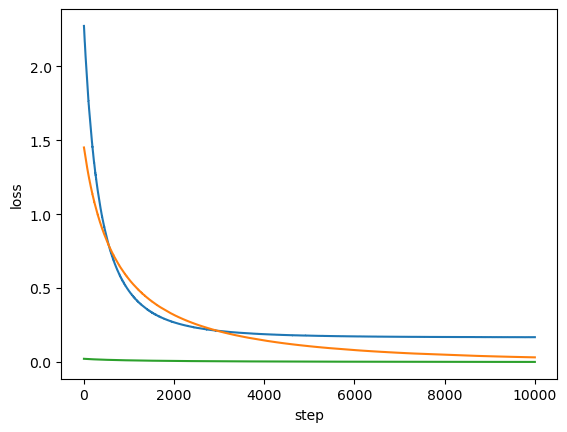

In [ ]:
sns.lineplot(stats_df, x='step', y='loss')
sns.lineplot(stats_df, x='step', y='D_dev')
sns.lineplot(stats_df, x='step', y='W_dev')

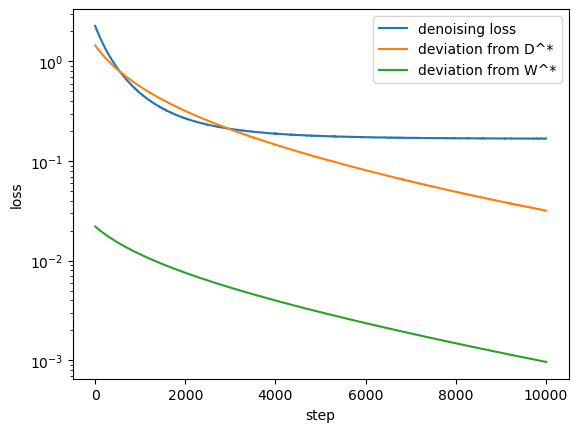

In [ ]:
# use log y scale
sns.lineplot(stats_df, x='step', y='loss', label='denoising loss')
sns.lineplot(stats_df, x='step', y='D_dev', label='deviation from D^*')
sns.lineplot(stats_df, x='step', y='W_dev', label='deviation from W^*')
plt.yscale('log')
# use interpreter tex 
plt.legend()

### Two layer symmetric linear case

In [48]:
# Parameters
n_dim = 784
batch_size = 2048
sigma = 0.5
total_steps = 10000
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
# lr = 0.001
# optim_fun = optim.Adam
lr = 1.0 #0.5
optim_fun = optim.SGD
# Create Gaussian Model parameters
# sample eigenvectors
U, _ = random_orthogonal(n_dim)
U = U.to(device)
# sample eigenvalues
Lambda = np.random.exponential(scale=1.0, size=(n_dim, ))
Lambda = sorted(Lambda, reverse=True)
Lambda = th.tensor(Lambda).float().to(device)
mu = th.zeros(n_dim).to(device)
Cov = U @ th.diag(Lambda) @ U.T

# optimal solution W_star
W_star_solu = Cov @ th.inverse(Cov + sigma ** 2 * th.eye(n_dim).to(device))
b_star_solu = mu - mu @ W_star_solu 

n_hidden = 4096
W_init_scale = 0.001
# Linear Model parameters
W = th.randn(n_dim, n_hidden).to(device) / math.sqrt(n_hidden) * W_init_scale
# b = th.randn(n_dim).to(device) / math.sqrt(n_dim)
b = th.zeros(n_dim).to(device)
W.requires_grad = True
b.requires_grad = True

# Optimizer
optimizer = optim_fun([W, b], lr=lr)
# Training loop 
stats_traj = []
W_dev_per_mode_col = []
for step in trange(total_steps):
    # Generate samples
    samples = generate_multivariate_gaussian(batch_size, n_dim, Lambda, U, mu, device=device)
    noised_samples = samples + sigma * th.randn_like(samples)
    # Forward pass
    Dx = noised_samples @ W @ W.T + b
    # loss = nn.MSELoss()(Dx, samples)
    loss = th.mean((Dx - samples) ** 2, dim=(0,1))
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with th.no_grad():
        W_eff = W @ W.T
        # Evaluate W, b to optimal solution
        W_deviation = (W_star_solu - W_eff).pow(2).mean().sqrt()
        W_deviation_per_mode = ((W_star_solu - W_eff) @ U).pow(2).sum(dim=0).sqrt()
        b_deviation = (b_star_solu - b).pow(2).mean().sqrt()
        denoiser_ideal = noised_samples @ W_star_solu + b_star_solu
        D_deviation = (denoiser_ideal - Dx).pow(2).mean().sqrt()
    # Printing and logging
    if (step + 1) % 1000 == 0 or step==0:
        print(f'Step {step + 1}, Loss {loss.item():.4f} W dev {W_deviation.item():.4f} b dev {b_deviation.item():.4f} D dev {D_deviation.item():.4f}')
    stats_traj.append({"step": step + 1, 
                       "loss": loss.item(), 
                       "W_dev": W_deviation.item(), 
                       "b_dev": b_deviation.item(), 
                       "D_dev": D_deviation.item()})
    W_dev_per_mode_col.append(W_deviation_per_mode.cpu().numpy())

stats_df = pd.DataFrame(stats_traj)
W_dev_per_mode_col = np.array(W_dev_per_mode_col)

  0%|          | 17/10000 [00:00<01:02, 160.25it/s]

Step 1, Loss 1.0458 W dev 0.0253 b dev 0.0001 D dev 0.9372


 10%|█         | 1022/10000 [00:05<00:44, 203.24it/s]

Step 1000, Loss 0.4264 W dev 0.0185 b dev 0.0006 D dev 0.5091


 20%|██        | 2030/10000 [00:10<00:39, 202.96it/s]

Step 2000, Loss 0.2398 W dev 0.0120 b dev 0.0004 D dev 0.2689


 30%|███       | 3038/10000 [00:14<00:34, 203.04it/s]

Step 3000, Loss 0.1987 W dev 0.0087 b dev 0.0004 D dev 0.1760


 40%|████      | 4025/10000 [00:20<00:29, 201.70it/s]

Step 4000, Loss 0.1845 W dev 0.0068 b dev 0.0003 D dev 0.1308


 50%|█████     | 5033/10000 [00:25<00:24, 203.26it/s]

Step 5000, Loss 0.1773 W dev 0.0054 b dev 0.0003 D dev 0.0982


 60%|██████    | 6020/10000 [00:29<00:19, 203.20it/s]

Step 6000, Loss 0.1737 W dev 0.0044 b dev 0.0003 D dev 0.0780


 70%|███████   | 7028/10000 [00:34<00:14, 203.01it/s]

Step 7000, Loss 0.1713 W dev 0.0036 b dev 0.0003 D dev 0.0620


 80%|████████  | 8036/10000 [00:39<00:09, 203.10it/s]

Step 8000, Loss 0.1703 W dev 0.0030 b dev 0.0003 D dev 0.0519


 90%|█████████ | 9023/10000 [00:44<00:04, 203.05it/s]

Step 9000, Loss 0.1699 W dev 0.0027 b dev 0.0003 D dev 0.0453


100%|██████████| 10000/10000 [00:49<00:00, 202.20it/s]

Step 10000, Loss 0.1691 W dev 0.0023 b dev 0.0003 D dev 0.0396


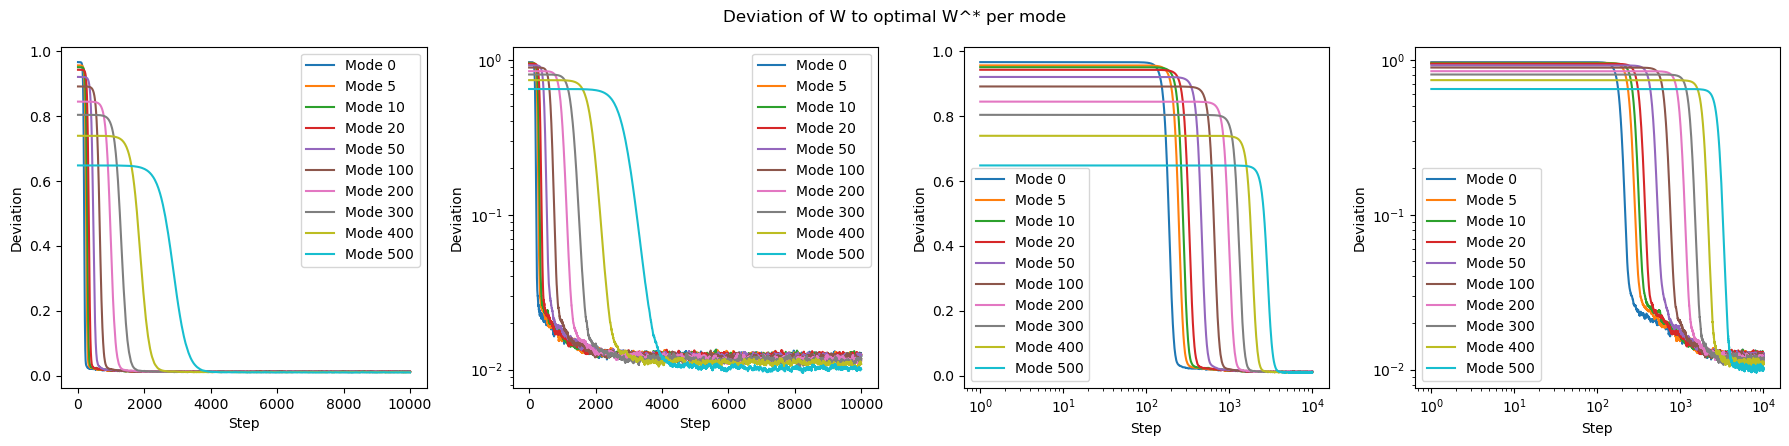

In [49]:
figh, axs = plt.subplots(1, 4, figsize=(18, 4.5))
axs = axs.flatten()
for i, plot_func in enumerate([plt.plot, plt.semilogy, plt.semilogx, plt.loglog]):
    plt.sca(axs[i])
    for eigenN in [0, 5, 10, 20, 50, 100, 200, 300, 400, 500]:
        plot_func(stats_df['step'], W_dev_per_mode_col[:, eigenN], label=f'Mode {eigenN}')
    plt.xlabel('Step')
    plt.ylabel('Deviation')
    plt.legend()
plt.suptitle('Deviation of W to optimal W^* per mode')
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


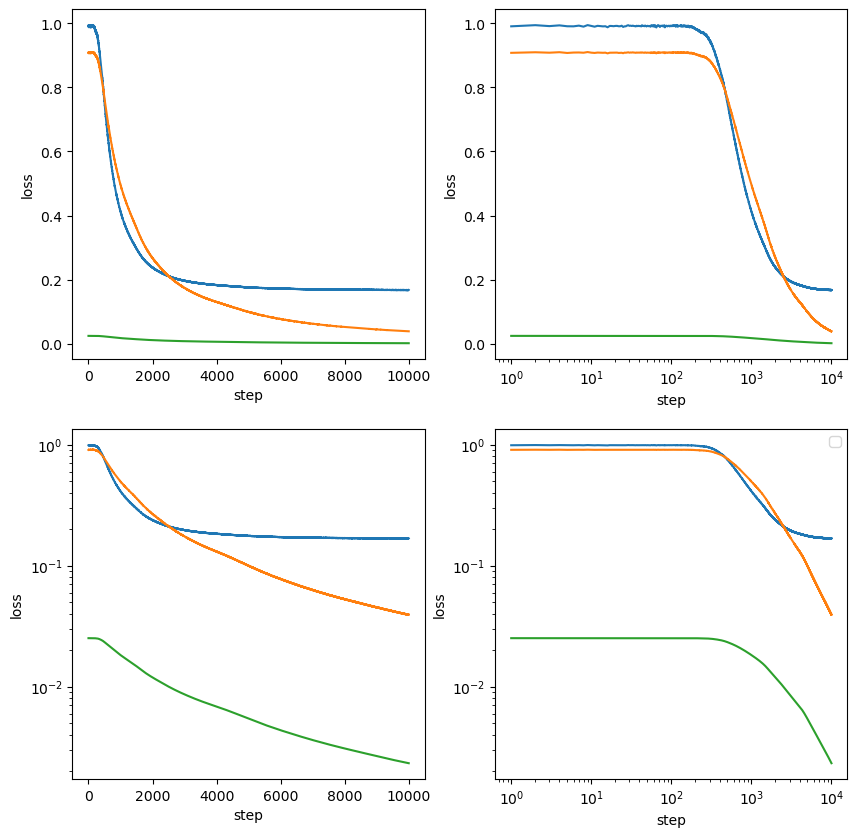

In [46]:
figh, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for i in range(4):
    sns.lineplot(stats_df, x='step', y='loss', ax=axs[i])
    sns.lineplot(stats_df, x='step', y='D_dev', ax=axs[i])
    sns.lineplot(stats_df, x='step', y='W_dev', ax=axs[i])
    if i % 2 == 1:
        axs[i].set_xscale('log')
    if i >= 2:
        axs[i].set_yscale('log')
# use interpreter tex 
plt.legend()

### Two layer non symmetric linear case

In [52]:
# Parameters
n_dim = 784
batch_size = 2048
sigma = 0.5
total_steps = 10000
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
# lr = 0.001
# optim_fun = optim.Adam
lr = 1.0 #0.5
optim_fun = optim.SGD
# Create Gaussian Model parameters
# sample eigenvectors
U, _ = random_orthogonal(n_dim)
U = U.to(device)
# sample eigenvalues
Lambda = np.random.exponential(scale=1.0, size=(n_dim, ))
Lambda = sorted(Lambda, reverse=True)
Lambda = th.tensor(Lambda).float().to(device)
mu = th.zeros(n_dim).to(device)
Cov = U @ th.diag(Lambda) @ U.T

# optimal solution W_star
W_star_solu = Cov @ th.inverse(Cov + sigma ** 2 * th.eye(n_dim).to(device))
b_star_solu = mu - mu @ W_star_solu 

n_hidden = 4096
W_init_scale = 0.001
# Linear Model parameters
W = th.randn(n_dim, n_hidden).to(device) / math.sqrt(n_hidden) * W_init_scale
W2 = th.randn(n_hidden, n_dim).to(device) / math.sqrt(n_hidden) * W_init_scale
# b = th.randn(n_dim).to(device) / math.sqrt(n_dim)
b = th.zeros(n_dim).to(device)
W.requires_grad = True
W2.requires_grad = True
b.requires_grad = True

# Optimizer
optimizer = optim_fun([W, W2, b], lr=lr)
# Training loop 
stats_traj = []
W_dev_per_mode_col = []
for step in trange(total_steps):
    # Generate samples
    samples = generate_multivariate_gaussian(batch_size, n_dim, Lambda, U, mu, device=device)
    noised_samples = samples + sigma * th.randn_like(samples)
    # Forward pass
    Dx = noised_samples @ W @ W2 + b
    # loss = nn.MSELoss()(Dx, samples)
    loss = th.mean((Dx - samples) ** 2, dim=(0,1))
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with th.no_grad():
        W_eff = W @ W2
        # Evaluate W, b to optimal solution
        W_deviation = (W_star_solu - W_eff).pow(2).mean().sqrt()
        W_deviation_per_mode = ((W_star_solu - W_eff) @ U).pow(2).sum(dim=0).sqrt()
        b_deviation = (b_star_solu - b).pow(2).mean().sqrt()
        denoiser_ideal = noised_samples @ W_star_solu + b_star_solu
        D_deviation = (denoiser_ideal - Dx).pow(2).mean().sqrt()
    # Printing and logging
    if (step + 1) % 1000 == 0 or step==0:
        print(f'Step {step + 1}, Loss {loss.item():.4f} W dev {W_deviation.item():.4f} b dev {b_deviation.item():.4f} D dev {D_deviation.item():.4f}')
    stats_traj.append({"step": step + 1, 
                       "loss": loss.item(), 
                       "W_dev": W_deviation.item(), 
                       "b_dev": b_deviation.item(), 
                       "D_dev": D_deviation.item()})
    W_dev_per_mode_col.append(W_deviation_per_mode.cpu().numpy())

stats_df = pd.DataFrame(stats_traj)
W_dev_per_mode_col = np.array(W_dev_per_mode_col)

  0%|          | 34/10000 [00:00<00:58, 170.12it/s]

Step 1, Loss 1.0255 W dev 0.0251 b dev 0.0001 D dev 0.9270


 10%|█         | 1021/10000 [00:05<00:44, 202.19it/s]

Step 1000, Loss 0.7299 W dev 0.0231 b dev 0.0007 D dev 0.7512


 20%|██        | 2029/10000 [00:10<00:39, 202.08it/s]

Step 2000, Loss 0.4333 W dev 0.0189 b dev 0.0006 D dev 0.5176


 30%|███       | 3037/10000 [00:15<00:34, 202.04it/s]

Step 3000, Loss 0.3088 W dev 0.0154 b dev 0.0005 D dev 0.3787


 40%|████      | 4024/10000 [00:19<00:29, 202.10it/s]

Step 4000, Loss 0.2495 W dev 0.0128 b dev 0.0004 D dev 0.2903


 50%|█████     | 5032/10000 [00:24<00:24, 202.11it/s]

Step 5000, Loss 0.2215 W dev 0.0110 b dev 0.0004 D dev 0.2373


 60%|██████    | 6040/10000 [00:29<00:19, 202.08it/s]

Step 6000, Loss 0.2042 W dev 0.0095 b dev 0.0004 D dev 0.1972


 70%|███████   | 7027/10000 [00:34<00:14, 202.02it/s]

Step 7000, Loss 0.1912 W dev 0.0081 b dev 0.0003 D dev 0.1623


 80%|████████  | 8035/10000 [00:39<00:09, 201.15it/s]

Step 8000, Loss 0.1835 W dev 0.0069 b dev 0.0003 D dev 0.1343


 90%|█████████ | 9022/10000 [00:44<00:04, 202.04it/s]

Step 9000, Loss 0.1788 W dev 0.0061 b dev 0.0003 D dev 0.1157


100%|██████████| 10000/10000 [00:49<00:00, 201.98it/s]

Step 10000, Loss 0.1754 W dev 0.0055 b dev 0.0003 D dev 0.1015


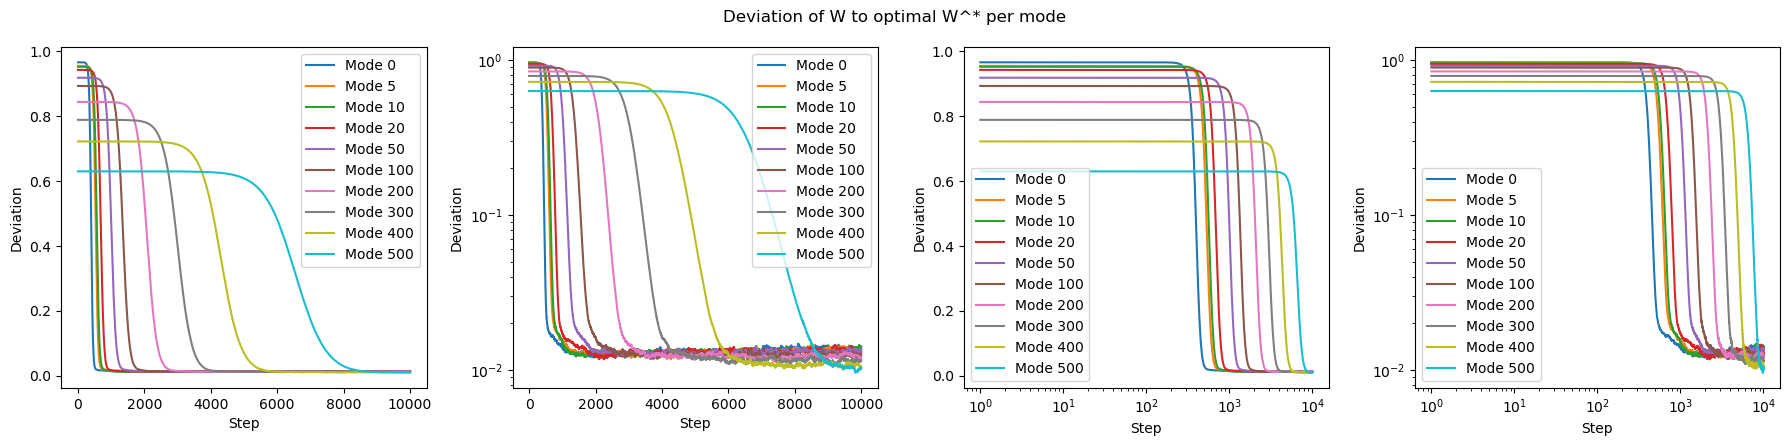

In [53]:
figh, axs = plt.subplots(1, 4, figsize=(18, 4.5))
axs = axs.flatten()
for i, plot_func in enumerate([plt.plot, plt.semilogy, plt.semilogx, plt.loglog]):
    plt.sca(axs[i])
    for eigenN in [0, 5, 10, 20, 50, 100, 200, 300, 400, 500]:
        plot_func(stats_df['step'], W_dev_per_mode_col[:, eigenN], label=f'Mode {eigenN}')
    plt.xlabel('Step')
    plt.ylabel('Deviation')
    plt.legend()
plt.suptitle('Deviation of W to optimal W^* per mode')
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


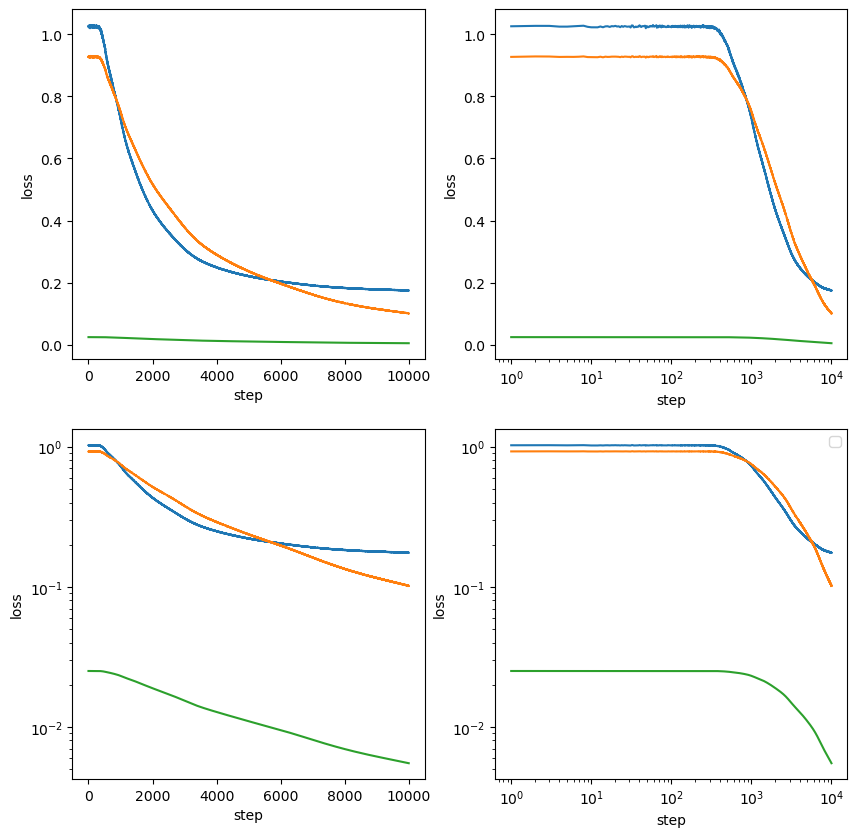

In [54]:
figh, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for i in range(4):
    sns.lineplot(stats_df, x='step', y='loss', ax=axs[i])
    sns.lineplot(stats_df, x='step', y='D_dev', ax=axs[i])
    sns.lineplot(stats_df, x='step', y='W_dev', ax=axs[i])
    if i % 2 == 1:
        axs[i].set_xscale('log')
    if i >= 2:
        axs[i].set_yscale('log')
# use interpreter tex 
plt.legend()

### Three layer arbitrary linear case

In [56]:
# Parameters
n_dim = 784
batch_size = 2048
sigma = 0.5
total_steps = 10000
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
# lr = 0.001
# optim_fun = optim.Adam
lr = 1.0 #0.5
optim_fun = optim.SGD
# Create Gaussian Model parameters
# sample eigenvectors
U, _ = random_orthogonal(n_dim)
U = U.to(device)
# sample eigenvalues
Lambda = np.random.exponential(scale=1.0, size=(n_dim, ))
Lambda = sorted(Lambda, reverse=True)
Lambda = th.tensor(Lambda).float().to(device)
mu = th.zeros(n_dim).to(device)
Cov = U @ th.diag(Lambda) @ U.T

# optimal solution W_star
W_star_solu = Cov @ th.inverse(Cov + sigma ** 2 * th.eye(n_dim).to(device))
b_star_solu = mu - mu @ W_star_solu 

n_hidden = 4096
W_init_scale = 1
# Linear Model parameters
W = th.randn(n_dim, n_hidden).to(device) / math.sqrt(n_hidden) * W_init_scale
W2 = th.randn(n_hidden, n_hidden).to(device) / math.sqrt(n_hidden) * W_init_scale
W3 = th.randn(n_hidden, n_dim).to(device) / math.sqrt(n_hidden) * W_init_scale
# b = th.randn(n_dim).to(device) / math.sqrt(n_dim)
b = th.zeros(n_dim).to(device)
W.requires_grad = True
W2.requires_grad = True
W3.requires_grad = True
b.requires_grad = True

# Optimizer
optimizer = optim_fun([W, W2, W3, b], lr=lr)
# Training loop 
stats_traj = []
W_dev_per_mode_col = []
for step in trange(total_steps):
    # Generate samples
    samples = generate_multivariate_gaussian(batch_size, n_dim, Lambda, U, mu, device=device)
    noised_samples = samples + sigma * th.randn_like(samples)
    # Forward pass
    Dx = noised_samples @ W @ W2 @ W3 + b
    # loss = nn.MSELoss()(Dx, samples)
    loss = th.mean((Dx - samples) ** 2, dim=(0,1))
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with th.no_grad():
        W_eff = W @ W2 @ W3
        # Evaluate W, b to optimal solution
        W_deviation = (W_star_solu - W_eff).pow(2).mean().sqrt()
        W_deviation_per_mode = ((W_star_solu - W_eff) @ U).pow(2).sum(dim=0).sqrt()
        b_deviation = (b_star_solu - b).pow(2).mean().sqrt()
        denoiser_ideal = noised_samples @ W_star_solu + b_star_solu
        D_deviation = (denoiser_ideal - Dx).pow(2).mean().sqrt()
    # Printing and logging
    if (step + 1) % 1000 == 0 or step==0:
        print(f'Step {step + 1}, Loss {loss.item():.4f} W dev {W_deviation.item():.4f} b dev {b_deviation.item():.4f} D dev {D_deviation.item():.4f}')
    stats_traj.append({"step": step + 1, 
                       "loss": loss.item(), 
                       "W_dev": W_deviation.item(), 
                       "b_dev": b_deviation.item(), 
                       "D_dev": D_deviation.item()})
    W_dev_per_mode_col.append(W_deviation_per_mode.cpu().numpy())

stats_df = pd.DataFrame(stats_traj)
W_dev_per_mode_col = np.array(W_dev_per_mode_col)

  0%|          | 10/10000 [00:00<03:41, 45.13it/s]

Step 1, Loss 1.2352 W dev 0.0291 b dev 0.0001 D dev 1.0348


 10%|█         | 1006/10000 [00:17<02:39, 56.31it/s]

Step 1000, Loss 0.1656 W dev 0.0015 b dev 0.0003 D dev 0.0313


 20%|██        | 2008/10000 [00:35<02:21, 56.33it/s]

Step 2000, Loss 0.1647 W dev 0.0007 b dev 0.0003 D dev 0.0210


 30%|███       | 3010/10000 [00:53<02:04, 56.33it/s]

Step 3000, Loss 0.1651 W dev 0.0006 b dev 0.0003 D dev 0.0205


 40%|████      | 4006/10000 [01:11<01:46, 56.33it/s]

Step 4000, Loss 0.1643 W dev 0.0006 b dev 0.0003 D dev 0.0205


 50%|█████     | 5008/10000 [01:28<01:28, 56.30it/s]

Step 5000, Loss 0.1646 W dev 0.0006 b dev 0.0003 D dev 0.0205


 60%|██████    | 6010/10000 [01:46<01:10, 56.31it/s]

Step 6000, Loss 0.1644 W dev 0.0006 b dev 0.0003 D dev 0.0204


 70%|███████   | 7006/10000 [02:04<00:53, 56.34it/s]

Step 7000, Loss 0.1651 W dev 0.0006 b dev 0.0003 D dev 0.0204


 80%|████████  | 8008/10000 [02:22<00:35, 56.34it/s]

Step 8000, Loss 0.1648 W dev 0.0006 b dev 0.0003 D dev 0.0204


 90%|█████████ | 9010/10000 [02:40<00:17, 56.33it/s]

Step 9000, Loss 0.1647 W dev 0.0006 b dev 0.0003 D dev 0.0203


100%|██████████| 10000/10000 [02:57<00:00, 56.31it/s]

Step 10000, Loss 0.1649 W dev 0.0006 b dev 0.0003 D dev 0.0203


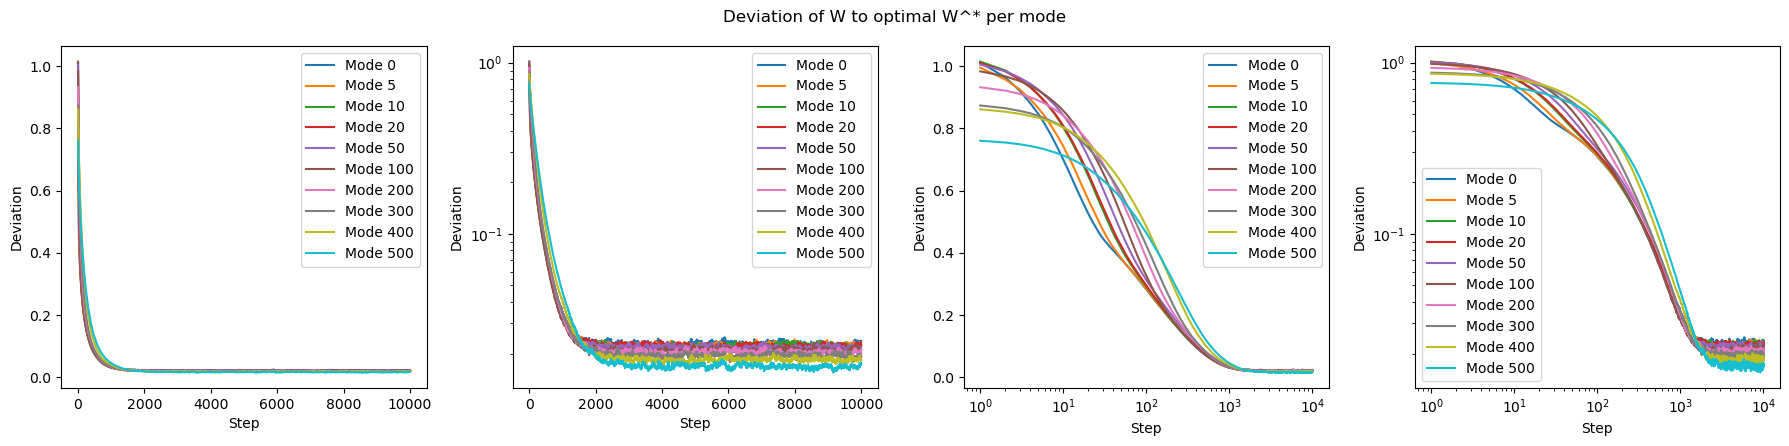

In [57]:
figh, axs = plt.subplots(1, 4, figsize=(18, 4.5))
axs = axs.flatten()
for i, plot_func in enumerate([plt.plot, plt.semilogy, plt.semilogx, plt.loglog]):
    plt.sca(axs[i])
    for eigenN in [0, 5, 10, 20, 50, 100, 200, 300, 400, 500]:
        plot_func(stats_df['step'], W_dev_per_mode_col[:, eigenN], label=f'Mode {eigenN}')
    plt.xlabel('Step')
    plt.ylabel('Deviation')
    plt.legend()
plt.suptitle('Deviation of W to optimal W^* per mode')
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


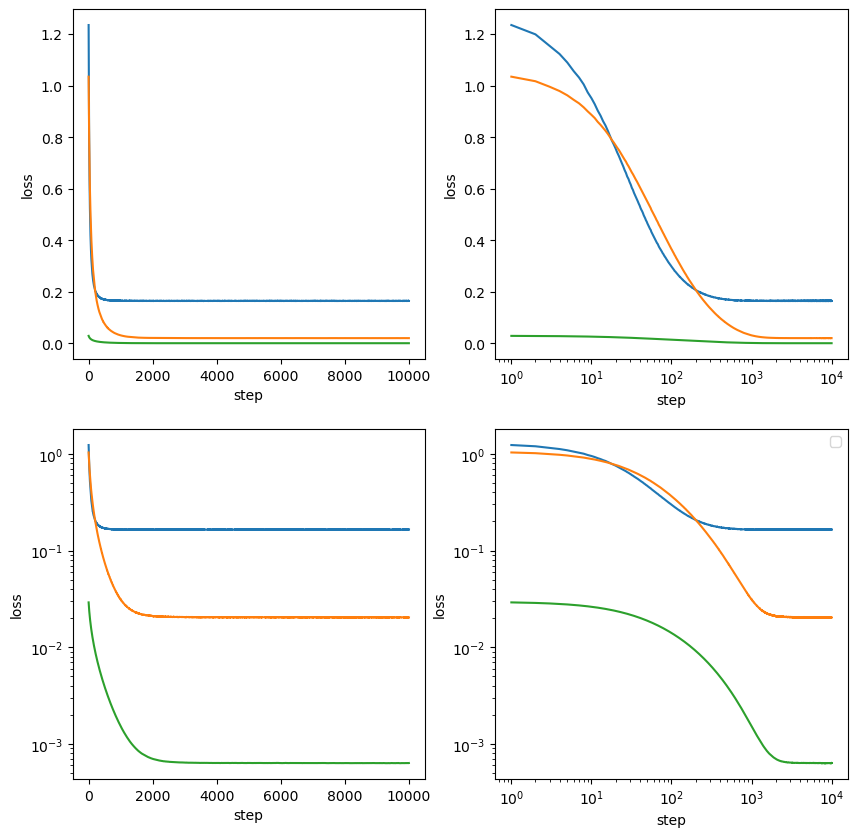

In [58]:
figh, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for i in range(4):
    sns.lineplot(stats_df, x='step', y='loss', ax=axs[i])
    sns.lineplot(stats_df, x='step', y='D_dev', ax=axs[i])
    sns.lineplot(stats_df, x='step', y='W_dev', ax=axs[i])
    if i % 2 == 1:
        axs[i].set_xscale('log')
    if i >= 2:
        axs[i].set_yscale('log')
# use interpreter tex 
plt.legend()